[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2b_cnn_mnist.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/notebooks/welcome?src=https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2b_cnn_mnist.ipynb)
[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2b_cnn_mnist.ipynb)
[![SageMaker](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2b_cnn_mnist.ipynb)

# Red convolucional: MNIST


<div style="text-align: right"> Bere et Richardt </div>

---

En esta libreta veremos un ejemplo de clasificación multiclase de imágenes de dígitos utilizando una red convolucional en PyTorch.

Emplearemos un conjunto referencia llamado [MNIST](http://yann.lecun.com/exdb/mnist/) recolectado por [Yann LeCun](http://yann.lecun.com). Está compuesto de imágenes en escala de grises de 28 × 28 píxeles que contienen dígitos entre 0 y 9 escritos a mano. El conjunto cuenta con 60,000 imágenes de entrenamiento y 10,000 de prueba.


<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width="600"/>
Conjunto MNIST. Imagen tomada de Wikipedia.

## 1 Preparación

In [1]:
# Colab
!pip install torch-summary

### 1.1 Bibliotecas

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
# inspección de arquitectura
# https://github.com/TylerYep/torch-summary
from torchsummary import summary
# barras de progreso
from tqdm import tqdm


# directorio de datos
DATA_DIR = '../data'

# MNIST
MEAN = 0.1307
STD = 0.3081

# tamaño del lote
BATCH_SIZE = 128

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### 1.2 Auxiliares

In [3]:
def display_grid(xs, titles, rows, cols):
    fig, ax = plt.subplots(rows, cols)
    for r in range(rows):
        for c in range(cols):
            i = r * rows + c
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
    fig.tight_layout()
    plt.show()

## 2 Datos

### 2.1 Tuberias de datos con PyTorch

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/f79e17e7aaf27b8c2cbae98c947a33b347ff0e8a/figs/mnist_tuberia.svg" width="1050"/>
&nbsp;
Tuberia de datos para MNIST.

### 2.2 Exploración

In [4]:
# creamos un Dataset
ds = MNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=True, 
    # convertir la imagen a ndarray
    transform=np.array, 
    # descargar el conjunto
    download=True
)

images[0] shape=(28, 28) dtype=uint8


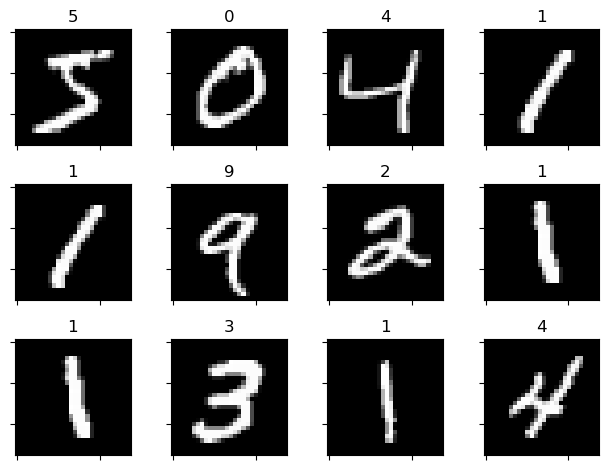

In [5]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(12):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, 3, 4)

### 2.3 Cargadores de datos


#### Entrenamiento

In [6]:
# transformaciones para la imagen
trn_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
trn_ds = MNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=trn_tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


#### Prueba

In [7]:
# transformaciones para la imagen
tst_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
tst_ds = MNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tst_tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# imprimimos forma y tipo del lote
for x, y in take(tst_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


## 3 Modelo

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/c468e943877056f243cd50e066863b7dd8bf9da5/figs/cnn_mnist1.svg" width="300"/>



### 3.1 Definición de la arquitectura

In [8]:
# definición del modelo
class CNN(nn.Module):
    
    # inicializador
    def __init__(self):
        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        self.num_feats = 4 * 14 * 14
        
        # definición de bloques conv
        # [N, 1, 28, 28] => [N, 4, 14, 14]
        self.cnn = nn.Sequential(
            # bloque conv1
            # [N, 1, 28, 28] => [N, 4, 28, 28]
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
            # [N, 4, 28, 28]
            nn.ReLU(),
            # [N, 4, 28, 28] => [N, 4, 14, 14]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )       
        
        # [N, 8, 7, 7] => [N, 4x14x14]
        self.flatten = nn.Flatten()

        # [N, 4x14x14] => [N, 1]
        self.cls = nn.Linear(self.num_feats, 10)
    
    # metodo para inferencia
    def forward(self, x):
        # [N, 1, 28, 28] => [N, 4, 14, 14]
        x = self.cnn(x)
        # [N, 4, 14, 14] => [N, 4x14x14]
        x = self.flatten(x)
        # [N, 4x14x14] => [N, 10]
        x = self.cls(x)
        return x

### 3.2 Inspección de la arquitectura

In [9]:
model = CNN()
print(model)

CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cls): Linear(in_features=784, out_features=10, bias=True)
)


In [10]:
summary(model, (1, 28, 28), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 14, 14]           --
|    └─Conv2d: 2-1                       [-1, 4, 28, 28]           40
|    └─ReLU: 2-2                         [-1, 4, 28, 28]           --
|    └─MaxPool2d: 2-3                    [-1, 4, 14, 14]           --
├─Flatten: 1-2                           [-1, 784]                 --
├─Linear: 1-3                            [-1, 10]                  7,850
Total params: 7,890
Trainable params: 7,890
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.03
Estimated Total Size (MB): 0.06

### Quiz 1

¿ Cómo se obtienen el número de parámetros que se muestra arriba?

### 3.3 Prueba de la arquitectura

In [11]:
# inferencia con datos sintéticos
x = torch.zeros(1, 1, 28, 28)
y = model(x)
print(y.shape)

torch.Size([1, 10])


## 4 Entrenamiento

### 4.1 Ciclo de entrenamiento

In [12]:
# creamos un modelo
model = CNN()

# optimizador
opt = optim.SGD(model.parameters(), lr=1e-3)
# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 7
for epoch in range(EPOCHS):
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # modelo en modo de evaluación
        model.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in take(tst_dl, 10):
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
        
        # agregagmos al historial de pérdidas
        loss_hist.append(loss)
        
        # modelo en modo de entrenamiento
        model.train()

E 0 loss= 85.85 acc=81.09
E 1 loss= 50.15 acc=87.89
E 2 loss= 43.61 acc=87.73
E 3 loss= 38.25 acc=90.00
E 4 loss= 36.56 acc=89.30
E 5 loss= 37.24 acc=89.53
E 6 loss= 30.26 acc=90.55


### 4.2 Gráfica de la pérdida

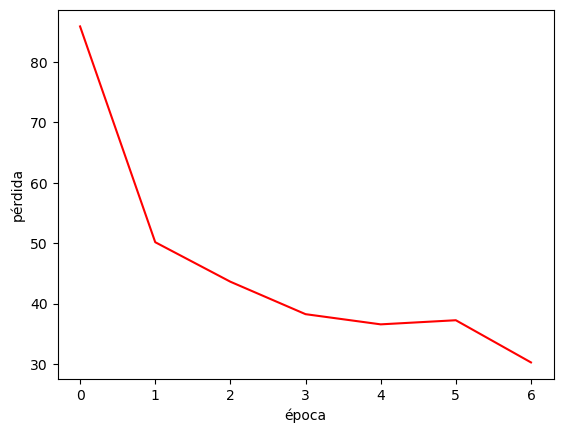

In [13]:
plt.plot(loss_hist, color='red')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

## 5 Evaluación

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2077b80363cfac8204826cb48b8ed51a5a41770e/figs/eval_trn_tst.svg" width="470"/>
&nbsp;
Entrenamiento con una partición de entrenamiento y prueba.

### 5.1 Conjunto de validación

In [14]:
# modelo en modo de evaluación
model.eval()

# evitamos que se registren las operaciones 
# en la gráfica de cómputo
with torch.no_grad(): 
        
    accs = []
    # validación de la época
    for x, y_true in tst_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos las probabilidades
        y_prob = F.softmax(y_lgts, 1)
        # obtenemos la clase predicha
        y_pred = torch.argmax(y_prob, 1)
        
        # calculamos la exactitud
        acc = (y_true == y_pred).type(torch.float32).mean()

        accs.append(acc.item() * 100)

    acc = np.mean(accs)

print(f'Exactitud = {acc:.2f}')

Exactitud = 90.37


### 5.2 Inferencia

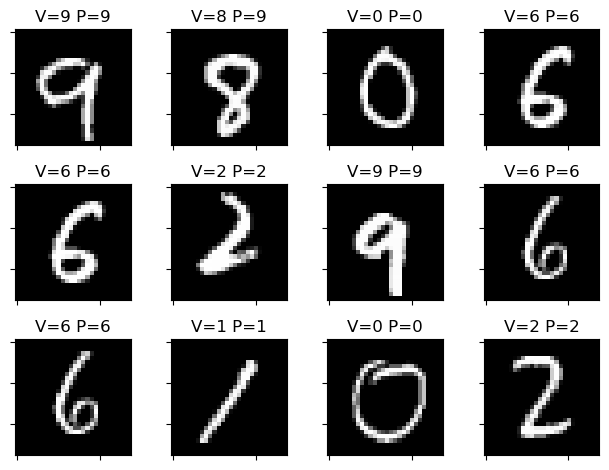

In [15]:
with torch.no_grad(): 
    for x, y_true in take(tst_dl, 1):
        y_lgts = model(x)
        y_prob = F.softmax(y_lgts, 1)
        y_pred = torch.argmax(y_prob, 1)

    x = x[:12].squeeze().numpy()
    y_true = y_true[:12].numpy()
    y_pred = y_pred[:12].numpy()

titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
display_grid(x, titles, 3, 4)